In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from catboost import CatBoostClassifier
from catboost import Pool

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head(10)

(165034, 14)


In [5]:
train_df.shape

(165034, 14)

In [5]:
na_sum_train = train_df.isna().sum()
na_sum_test = test_df.isna().sum()

print("Na Sum Train:")
print(f'{na_sum_train}\n')

print("Na Sum Test:")
print(f'{na_sum_test}\n')

Na Sum Train:
id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Na Sum Test:
id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64



In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [7]:
categorical_feature = [feature for feature in train_df.columns if train_df[feature].dtype == 'object']
categorical_feature

['Surname', 'Geography', 'Gender']

In [8]:

def label_encode(train_df):
    trial = train_df.copy()
    le = LabelEncoder()
    for feature in categorical_feature:
        trial[feature] = le.fit_transform(trial[feature])
        
    return trial


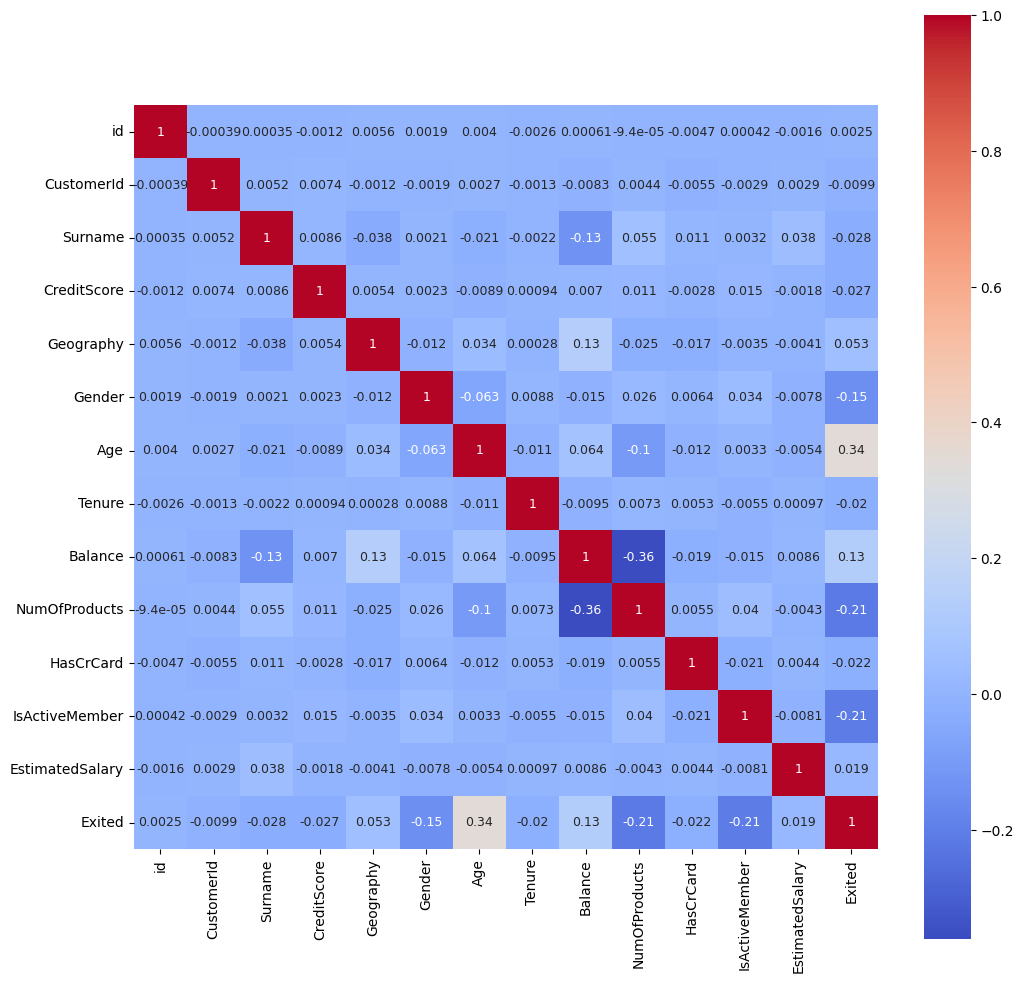

In [9]:
trial = label_encode(train_df)

cormat = trial.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(cormat, cbar=True, annot=True, square=True,annot_kws={'size': 9},yticklabels=train_df.columns, xticklabels=train_df.columns,cmap="coolwarm")
plt.show()

Feature Scaling

In [10]:

numeric_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

for col in numeric_cols:
    sc = MinMaxScaler()
    train_df[col+'_Scaled'] = sc.fit_transform(train_df[[col]])
    test_df[col+'_Scaled'] = sc.fit_transform(test_df[[col]])


In [11]:
train_df['Sur_Geo_Gend_Sal'] = train_df['CustomerId'].astype('str')+train_df['Surname']+train_df['Geography']+train_df['Gender']+np.round(train_df.EstimatedSalary).astype('str')
test_df['Sur_Geo_Gend_Sal'] = test_df['CustomerId'].astype('str')+test_df['Surname']+test_df['Geography']+test_df['Gender']+np.round(test_df.EstimatedSalary).astype('str')

Vectorizer and Dimensionality Reduction

*TF-IDF (Term Frequency-Inverse Document Frequency) vectorization is a technique commonly used in natural language processing (NLP) to represent textual data numerically. It converts a collection of text documents into a matrix of numerical features, where each row corresponds to a document, and each column corresponds to a unique term in the entire corpus

*TF-IDF vectorization, as it is designed for processing and extracting features from textual information.

*When we Apply TF-IDF to the "Surname" column in our dataset, we'll gain insights into the importance of different surnames across the entire dataset. TF-IDF will assign weights to each surname based on how frequently they appear in a particular entry (Term Frequency) and how unique they are across the entire dataset (Inverse Document Frequency).

*Applying TF-IDF to the "Surname" column may necessitate preprocessing steps, such as handling variations in case or stemming, to ensure that similar surnames are treated consistently. Additionally, the TF-IDF scores can be used as features for machine learning models.

*TF-IDF will highlight surnames that are unique or less common in the dataset. Surnames with higher TF-IDF scores are those that appear frequently in a specific record but less frequently across the entire dataset.

*If you apply TF-IDF vectorization to this "Surname" column and then use techniques like dimensionality reduction with SVD, it makes sense in the context of processing textual data for machine learning. This approach can help capture the importance of different words (in this case, surnames) and potentially improve the performance of your machine learning model.

In [12]:

def get_vectors(train_df,test_df,col_name):

    vectorizer = TfidfVectorizer(max_features=1000)
    vectors_train = vectorizer.fit_transform(train_df[col_name])
    vectors_test = vectorizer.transform(test_df[col_name])
    
    #Dimensionality Reduction Using SVD ( Singular Value Decompostion)
    svd = TruncatedSVD(3)
    x_sv_train = svd.fit_transform(vectors_train)
    x_sv_test = svd.transform(vectors_test)

    # Convert to DataFrames
    tfidf_df_train = pd.DataFrame(x_sv_train)
    tfidf_df_test = pd.DataFrame(x_sv_test)

    # Naming columns in the new DataFrames
    cols = [(col_name + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
    tfidf_df_train.columns = cols
    tfidf_df_test.columns = cols

    # Reset the index of the DataFrames before concatenation
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    # Concatenate transformed features with original data
    train_df = pd.concat([train_df, tfidf_df_train], axis="columns")
    test_df = pd.concat([test_df, tfidf_df_test], axis="columns")
    
    
    return train_df,test_df


Question1: Why is TfidfVectorizer used, and what is the significance of max_features=1000?

TfidfVectorizer is used to convert text data into TF-IDF features, which capture the importance of terms in a document collection. max_features=1000 limits the number of unique terms considered to the top 1000 most frequent terms. This helps control the dimensionality of the resulting TF-IDF matrix, focusing on the most informative features.

Question2: What is the purpose of applying TruncatedSVD for dimensionality reduction?

TruncatedSVD is applied to reduce the dimensionality of the TF-IDF matrix. This is done to mitigate the "curse of dimensionality" and to speed up subsequent machine learning algorithms. In this case, it reduces the number of features from the TF-IDF vectorization to three components

Question3: Why are the transformed features stored in new DataFrames (tfidf_df_train and tfidf_df_test)?

The transformed features obtained after applying TruncatedSVD are stored in new DataFrames (tfidf_df_train and tfidf_df_test). This is done for clarity and to facilitate easy naming of the new features. It allows for a clear separation between the original features and the newly created TF-IDF features.

In [13]:
train_df,test_df = get_vectors(train_df,test_df,'Surname')

train_df,test_df = get_vectors(train_df,test_df,'Sur_Geo_Gend_Sal')

In [14]:
# Dataframe after Vectorization
train_df.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,Age_Scaled,Balance_Scaled,EstimatedSalary_Scaled,Sur_Geo_Gend_Sal,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Sur_Geo_Gend_Sal_tfidf_0,Sur_Geo_Gend_Sal_tfidf_1,Sur_Geo_Gend_Sal_tfidf_2
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,0.202703,0.000000,0.907279,15674932OkwudilichukwuFranceMale181450.0,3.181348e-09,2.439489e-06,3.189659e-07,0.0,0.0,0.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,0.202703,0.000000,0.247483,15749177OkwudiliolisaFranceMale49504.0,3.776471e-07,-1.100194e-06,-2.942686e-06,0.0,0.0,0.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,0.297297,0.000000,0.924364,15694510HsuehFranceMale184867.0,1.186021e-03,4.040583e-03,4.043147e-03,0.0,0.0,0.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,0.216216,0.593398,0.422787,15741417KaoFranceMale84561.0,3.255407e-04,1.681914e-03,1.977240e-03,0.0,0.0,0.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,0.202703,0.000000,0.075293,15766172ChiemenamSpainMale15069.0,-1.298531e-07,2.323539e-07,2.773366e-07,0.0,0.0,0.0
5,5,15771669,Genovese,588,Germany,Male,36.0,4,131778.58,1,...,0.243243,0.525228,0.680129,15771669GenoveseGermanyMale136024.0,-2.351658e-05,-1.177892e-03,-2.009925e-04,0.0,0.0,0.0
6,6,15692819,Ch'ang,593,France,Female,30.0,8,144772.69,1,...,0.162162,0.577018,0.148917,15692819Ch'angFranceFemale29792.0,5.370558e-01,-7.352897e-03,-6.102429e-01,0.0,0.0,0.0
7,7,15669611,Chukwuebuka,678,Spain,Male,37.0,1,138476.41,1,...,0.256757,0.551923,0.534251,15669611ChukwuebukaSpainMale106852.0,5.167611e-08,7.491121e-08,1.367812e-07,0.0,0.0,0.0
8,8,15691707,Manna,676,France,Male,43.0,4,0.00,2,...,0.337838,0.000000,0.714596,15691707MannaFranceMale142917.0,5.653503e-04,1.644073e-03,3.943868e-03,0.0,0.0,0.0
9,9,15591721,Cattaneo,583,Germany,Male,40.0,4,81274.33,1,...,0.297297,0.323934,0.854239,15591721CattaneoGermanyMale170843.0,3.031430e-07,-2.310828e-06,-1.848922e-06,0.0,0.0,0.0


In [15]:
def feature_data(df):

    df['Senior'] = df['Age'].apply(lambda x: 1 if x >= 65 else 0)
    df['Active_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
    df['Tenure_by_Age'] = df['Tenure'] / df['Age']
    df['AgeCat'] = np.round(df.Age/20).astype('int').astype('category')

    cat_cols = ['Geography', 'Gender', 'NumOfProducts','AgeCat']

    #onehotEncoding
    df=pd.get_dummies(df,columns=cat_cols)
    
    return df


In [16]:
#Genrating New Features
train_df = feature_data(train_df)
test_df = feature_data(test_df)

##Selecting Columns FOr use 
feat_cols=train_df.columns.drop(['id', 'CustomerId', 'Surname','Exited','Sur_Geo_Gend_Sal'])
feat_cols=feat_cols.drop(numeric_cols)

#Printing
print(feat_cols)
train_df.head()

Index(['Tenure', 'HasCrCard', 'IsActiveMember', 'CreditScore_Scaled',
       'Age_Scaled', 'Balance_Scaled', 'EstimatedSalary_Scaled',
       'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_2',
       'Sur_Geo_Gend_Sal_tfidf_0', 'Sur_Geo_Gend_Sal_tfidf_1',
       'Sur_Geo_Gend_Sal_tfidf_2', 'Senior', 'Active_by_CreditCard',
       'Tenure_by_Age', 'Geography_France', 'Geography_Germany',
       'Geography_Spain', 'Gender_Female', 'Gender_Male', 'NumOfProducts_1',
       'NumOfProducts_2', 'NumOfProducts_3', 'NumOfProducts_4', 'AgeCat_1',
       'AgeCat_2', 'AgeCat_3', 'AgeCat_4', 'AgeCat_5'],
      dtype='object')


,id,CustomerId,Surname,CreditScore,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,...,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4,AgeCat_5
0,0,15674932,Okwudilichukwu,668,33.0,3,0.00,1.0,0.0,181449.97,...,True,False,True,False,False,False,True,False,False,False
1,1,15749177,Okwudiliolisa,627,33.0,1,0.00,1.0,1.0,49503.50,...,True,False,True,False,False,False,True,False,False,False
2,2,15694510,Hsueh,678,40.0,10,0.00,1.0,0.0,184866.69,...,True,False,True,False,False,False,True,False,False,False
3,3,15741417,Kao,581,34.0,2,148882.54,1.0,1.0,84560.88,...,True,True,False,False,False,False,True,False,False,False
4,4,15766172,Chiemenam,716,33.0,5,0.00,1.0,1.0,15068.83,...,True,False,True,False,False,False,True,False,False,False


In [17]:
X=train_df[feat_cols]
y=train_df['Exited']

print(X.shape)

(165034, 30)


In [40]:
X.head()

,Tenure,HasCrCard,IsActiveMember,CreditScore_Scaled,Age_Scaled,Balance_Scaled,EstimatedSalary_Scaled,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,...,Gender_Male,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,AgeCat_1,AgeCat_2,AgeCat_3,AgeCat_4,AgeCat_5
0,3,1.0,0.0,0.636,0.202703,0.000000,0.907279,3.181348e-09,2.439489e-06,3.189659e-07,...,True,False,True,False,False,False,True,False,False,False
1,1,1.0,1.0,0.554,0.202703,0.000000,0.247483,3.776471e-07,-1.100194e-06,-2.942686e-06,...,True,False,True,False,False,False,True,False,False,False
2,10,1.0,0.0,0.656,0.297297,0.000000,0.924364,1.186021e-03,4.040583e-03,4.043147e-03,...,True,False,True,False,False,False,True,False,False,False
3,2,1.0,1.0,0.462,0.216216,0.593398,0.422787,3.255407e-04,1.681914e-03,1.977240e-03,...,True,True,False,False,False,False,True,False,False,False
4,5,1.0,1.0,0.732,0.202703,0.000000,0.075293,-1.298531e-07,2.323539e-07,2.773366e-07,...,True,False,True,False,False,False,True,False,False,False


LightGBM Classifier

In [21]:

params = {
    'n_estimators': [1500],
    'max_depth': [45], 
    'learning_rate':[0.025],
    'min_child_weight': [4.43],
    'min_child_samples': [256],
    'subsample': [0.802],
    'subsample_freq': [4],
    'colsample_bytree': [0.31],
    'num_leaves': [25],
    'verbosity': [-1],
}

model = LGBMClassifier()

# Perform grid search
random_search = RandomizedSearchCV(
    model, 
    param_distributions= params, 
    n_iter=100,  # Reduced number of iterations for a quicker search
    scoring='roc_auc',  # Use ROC AUC as the scoring metric
    cv=5,  # Reduced number of folds
    verbose=1, 
    n_jobs=-1,  # Use all available cores
    random_state=42
)
random_search.fit(X, y)

# Use the best estimator found by the grid search
best_lgbm = random_search.best_estimator_

# use best_lgbm to make predictions or further evaluations
best_lgbm.fit(X, y)




Fitting 5 folds for each of 1 candidates, totalling 5 fits


LGBMClassifier(colsample_bytree=0.31, learning_rate=0.025, max_depth=45,
               min_child_samples=256, min_child_weight=4.43, n_estimators=1500,
               num_leaves=25, subsample=0.802, subsample_freq=4, verbosity=-1)

In [22]:
best_params = random_search.best_params_


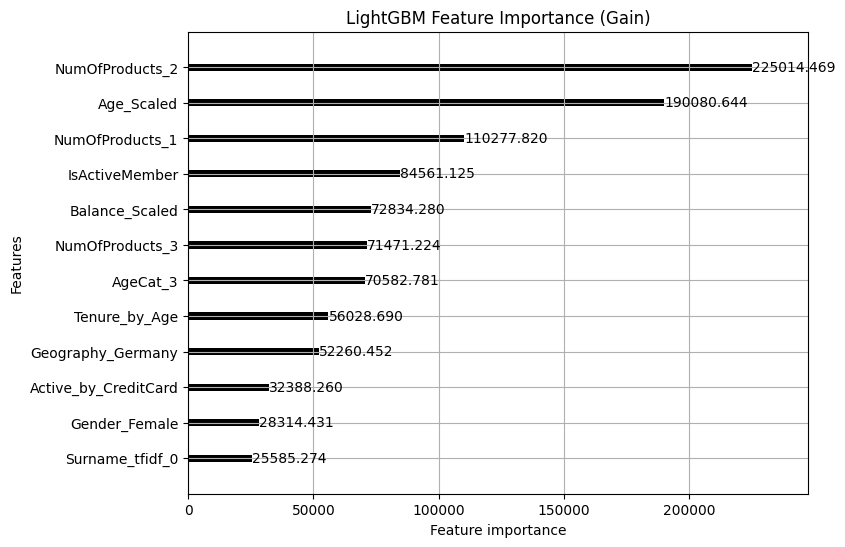

In [23]:
# Feature Importance Using LightGBM

lgb_model=LGBMClassifier(**best_params)
lgb_model.fit(X, y)
plot_importance(lgb_model, importance_type="gain", figsize=(8,6), max_num_features=12, color = "black", title="LightGBM Feature Importance (Gain)")
plt.show()

In [24]:
feat_cols = X.columns

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
test_preds = np.empty((10, len(test_df)))
auc_vals = []

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):

    X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
    X_test_fold, y_test_fold = X.iloc[valid_idx], y.iloc[valid_idx]

    #LGB Classifier
    lgbm = LGBMClassifier(**best_params)
    lgbm.fit(X_train_fold, y_train_fold, eval_set=[(X_test_fold, y_test_fold)], eval_metric='roc_auc')

    #Predicting on validation set and Printing Results.
    y_pred_val = lgbm.predict_proba(X_test_fold[feat_cols])[:, 1]
    auc_val = roc_auc_score(y_test_fold, y_pred_val)
    print(f"AUC for fold {n_fold}: {auc_val}")
    auc_vals.append(auc_val)

    y_pred_test_light = lgbm.predict_proba(test_df[feat_cols])[:, 1]
    test_preds[n_fold, :] = y_pred_test_light
    print("---- ---- Fold Completed ---- ----")


print('\nLoop finished Successfully')

AUC for fold 0: 0.895852161226451
---- ---- Fold Completed ---- ----
AUC for fold 1: 0.8915893655658059
---- ---- Fold Completed ---- ----
AUC for fold 2: 0.8964766068434846
---- ---- Fold Completed ---- ----
AUC for fold 3: 0.8936716609872467
---- ---- Fold Completed ---- ----
AUC for fold 4: 0.8925424851982238
---- ---- Fold Completed ---- ----
AUC for fold 5: 0.9007711269598913
---- ---- Fold Completed ---- ----
AUC for fold 6: 0.8940675076855843
---- ---- Fold Completed ---- ----
AUC for fold 7: 0.8989843865482401
---- ---- Fold Completed ---- ----
AUC for fold 8: 0.8937636080775074
---- ---- Fold Completed ---- ----
AUC for fold 9: 0.8918319004546598
---- ---- Fold Completed ---- ----

Loop finished Successfully


In [25]:
#The mean AUC value across all folds

mean_auc_light = np.mean(auc_vals)
print(f"\nMean AUC Of LightGBM : {mean_auc_light}")


Mean AUC Of LightGBM : 0.8949550809547097


## CatBoost Classifier

In [27]:
# Features to use
feat_cols = X.columns

# #Intilize folds 
# n = 5

#Cat_features
cat_features = np.where(X.dtypes != np.float64)[0]

# Initialize StratifiedKFold
folds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
test_preds = np.empty((10, len(test_df)))
auc_vals_cat = []

# Loop through folds 
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
    X_test_fold, y_test_fold = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train_fold, y_train_fold,cat_features=cat_features)
    val_pool = Pool(X_test_fold, y_test_fold,cat_features=cat_features)
    
    cat_model = CatBoostClassifier(eval_metric='AUC',learning_rate=0.022,iterations=1000)
    cat_model.fit(train_pool, eval_set=val_pool,verbose=False)
    
    #Predicting Prohabilites 
    y_pred_val_cat = cat_model.predict_proba(X_test_fold[feat_cols])[:,1]
    auc_val = roc_auc_score(y_test_fold, y_pred_val_cat)
    print("AUC for fold ",n_fold,": ",auc_val)
    auc_vals_cat.append(auc_vals)
    
    y_pred_test_cat = cat_model.predict_proba(test_df[feat_cols])[:,1]
    test_preds[n_fold, :] = y_pred_test_cat
    print(f"--- --- Loop Completed for Fold {n_fold} --- ---")

AUC for fold  0 :  0.8946708127205867
--- --- Loop Completed for Fold 0 --- ---
AUC for fold  1 :  0.8907490319095704
--- --- Loop Completed for Fold 1 --- ---
AUC for fold  2 :  0.8945612456067517
--- --- Loop Completed for Fold 2 --- ---
AUC for fold  3 :  0.8911241898137987
--- --- Loop Completed for Fold 3 --- ---
AUC for fold  4 :  0.8902489593130423
--- --- Loop Completed for Fold 4 --- ---
AUC for fold  5 :  0.8986163615367136
--- --- Loop Completed for Fold 5 --- ---
AUC for fold  6 :  0.8917255053284281
--- --- Loop Completed for Fold 6 --- ---
AUC for fold  7 :  0.897085847617
--- --- Loop Completed for Fold 7 --- ---
AUC for fold  8 :  0.8924195827603095
--- --- Loop Completed for Fold 8 --- ---
AUC for fold  9 :  0.8897956245147401
--- --- Loop Completed for Fold 9 --- ---


In [28]:
mean_auc_cat = np.mean(auc_vals_cat)
print(f"\nMean AUC Of CatBoost : {mean_auc_cat}")


Mean AUC Of CatBoost : 0.8949550809547095


In [31]:
fig = go.Figure()
# Background color
fig.update_layout(
    plot_bgcolor="#E8CE9D",  # Set background color for the entire plot area
    paper_bgcolor="#E8CE9D",  # Set background color for the outer area
)
# Define bar colors
bar_colors = ['#764a23', '#764a23']  # Colors for LightGBM and CatBoost respectively

fig.add_trace(go.Bar(
    x=['LightGBM Model Classifier', 'CatBoost Classifier'],
    y=[mean_auc_light, mean_auc_cat],
    name='AUC_Score',
    marker_color=bar_colors  # Set bar colors
))
# Update layout
fig.update_layout(
    title_text='AUC Comparison On Original Dataset',
    xaxis=dict(title='Classifier'),  # Set x-axis title
    yaxis=dict(title='AUC Score')  # Set y-axis title
)

fig.show()

In [30]:
models = ['LightGBM Classifier', 'CatBoost Classifier']
auc_Scores_models_scores = [mean_auc_light, mean_auc_cat]

# Find the index of the maximum AUc_Score
best_accuracy_index = auc_Scores_models_scores.index(max(auc_Scores_models_scores))

# Print the best model for accuracy
print(f'Best Accuracy: {auc_Scores_models_scores[best_accuracy_index]:.2f} with Model: {models[best_accuracy_index]}')

Best Accuracy: 0.89 with Model: LightGBM Classifier
